# Predicting Airbnb Listing Prices in Seattle

By: Josh Keating, Ethan Katnic, Christian Hahn, Robin Yang

## Framing the Problem

The purpose of this project is to identify the aspects of Airbnb host listings that have a correlation to the price of bookings. This information will allow Airbnb hosts to find and improve certain variables of their listing that are the highest indicators when it comes to setting price. Our predictive model can provide rough estimates as to how much your Airbnb in Seattle should be listed at based on your listing criteria. 

The dataset used was the Seattle Airbnb Open Dataset found on Kaggle (https://www.kaggle.com/airbnb/seattle#calendar.csv). The two CSV files we are using from this set are calendar.csv and listings.csv. The calendar file displays the listing_id, the dates, whether it is available on that date, and the price of booking for that day. The listings file includes a wide variety of metadata scraped from the listing url.

On top of the given columns in the dataset, we used the Microsoft Azure Text Sentiment Analysis API to calculate the sentiment value (on a scale of 1 - 100) of the listing summary. Positive and negative sentiment can be identified and perhaps has a correlation to number of bookings. This was done using post requests on Postman and is located in a file as scores.csv. 

As an additional insight, we also included exploratory analysis through a predictive model on the ratings of listings at the bottom of the notebook.

## Import Libraries and Data
See clean-data.ipynb for detail on data prep

In [1]:
#import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

In [2]:
# read in clean data
airbnb_data_dummies = pd.read_csv('data/cleaned-listings-dummies.csv')
airbnb_data_basic = pd.read_csv('data/cleaned-listings-base.csv')


## Initial Price Regression
In this section, we take a look at which features **correlate with the listing price** of an Airbnb. We performed a basic ordinary least squares regression, predicting price using a few dozen variables included in our dataset that we felt may be predictive of price. Variables exluded were either almost entirely NaN, or only contained a single value for >90% of listings.

In [3]:
formula = 'price ~ host_response_rate + accommodates + guests_included + bathrooms + bedrooms + beds + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + score + host_is_superhost + neighbourhood_Ballard  + neighbourhood_Cascade  + neighbourhood_Delridge + neighbourhood_Downtown + neighbourhood_Interbay + neighbourhood_Magnolia + neighbourhood_Northgate + property_type_Apartment  + property_type_Condominium + property_type_House + property_type_Loft + property_type_Townhouse + neighbourhood_Beacon_Hill + neighbourhood_Capitol_Hill + neighbourhood_Central_Area + neighbourhood_Lake_City + neighbourhood_Other_neighborhoods + neighbourhood_Queen_Anne + neighbourhood_Rainier_Valley + neighbourhood_Seward_Park + neighbourhood_University_District + neighbourhood_West_Seattle + property_type_Bed_Breakfast + room_type_Entire_home_apt + room_type_Private_room + room_type_Shared_room'

mod1 = smf.ols(formula=formula, data=airbnb_data_dummies).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     130.4
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:47:45   Log-Likelihood:                -20310.
No. Observations:                3705   AIC:                         4.070e+04
Df Residuals:                    3665   BIC:                         4.095e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -38.1985     15.877     -2.406      0.016     -69.327      -7.070
host_response_rate                   -0.1517      0.089     -1.697      0.090      -0.327       0.024
accommodates                          7.5074      1.171      6.412      0.000       5.212       9.803
guests_included                       3.3175      0.877      3.781      0.000       1.597       5.038
bathrooms                            27.5263      2.229     12.350      0.000      23.156      31.896
bedrooms                             32.3673      2.044     15.832      0.000      28.359      36.376
beds                                  1.0758      1.777      0.605      0.545      -2.408       4.560
number_of_reviews                    -0.1538      0.028     -5.505      0.000      -0.209      -0.099
review_scores_rating                  0.6969      0.265      2.628      0.009       0.177       1.217
review_scores_accuracy                2.7688      2.038      1.359      0.174      -1.226       6.764
review_scores_cleanliness             2.4932      1.785      1.397      0.163      -1.007       5.993
review_scores_checkin                -0.5157      2.521     -0.205      0.838      -5.458       4.426
review_scores_communication           0.3984      2.704      0.147      0.883      -4.904       5.701
review_scores_location                4.4394      1.965      2.260      0.024       0.588       8.291
review_scores_value                  -8.4751      2.048     -4.137      0.000     -12.491      -4.459
score                                -3.3947      5.496     -0.618      0.537     -14.170       7.381
host_is_superhost                     7.1544      2.561      2.794      0.005       2.134      12.175
neighbourhood_Ballard                -6.7646      4.258     -1.589      0.112     -15.112       1.583
neighbourhood_Cascade                23.9847      6.400      3.748      0.000      11.437      36.532
neighbourhood_Delridge              -24.4239      6.541     -3.734      0.000     -37.249     -11.599
neighbourhood_Downtown               33.2335      3.466      9.589      0.000      26.439      40.028
neighbourhood_Interbay                8.5666     17.567      0.488      0.626     -25.875      43.008
neighbourhood_Magnolia               17.3982      7.365      2.362      0.018       2.959      31.838
neighbourhood_Northgate             -30.3875      6.773     -4.487      0.000     -43.667     -17.108
property_type_Apartment             -17.6228      3.769     -4.675      0.000     -25.013     -10.232
property_type_Condominium           -12.4280      6.382     -1.947      0.052     -24.940       0.084
property_type_House                 -10.9984      3.748     -2.935      0.003     -18.346      -3.650
property_type_Loft     

Overall, our regression had an R-squared of **.581**, indicating that the variables we have at least explain the majority of variation in listing pricing. 

Unsurprisingly, features like `bathrooms`, `bedrooms`, and `number of guests` the listing can accommodate have strong positive relationships with `price`. 

Disappointingly, our positivity encoding for listing summary (`score` in the regression above) was not a significant variable, indicating that there is no relationship between how positive the list summary is and the pricing of the Airbnb. We anticipated a positive relationship here, as we expected listings with more detailed and colorful language to generally be nicer listings and would in turn have higher listing prices.


## Exploratory Data Visualizations

### Correlation Heatmap
We first built a heatmap to observe the relationships between variables. The values are squared to see simple correlations rather than including negative correlations. 

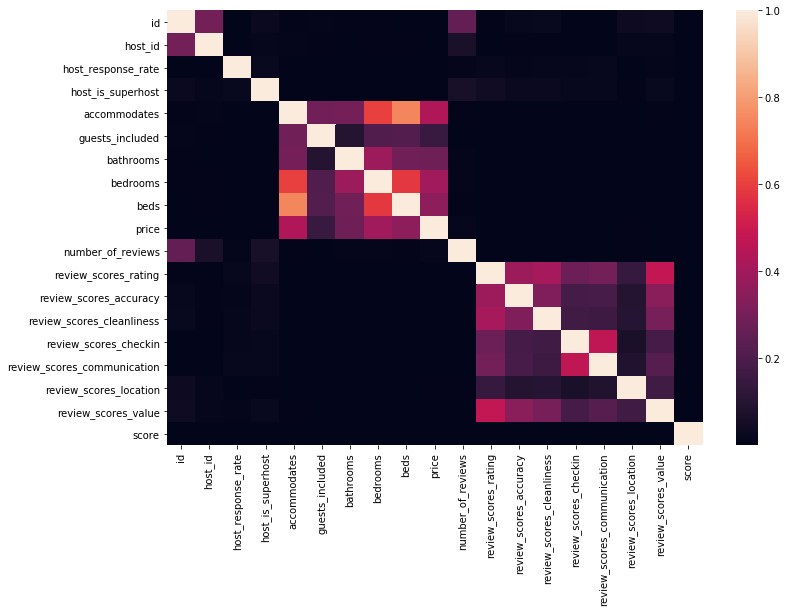

In [5]:
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(airbnb_data_basic.corr()**2, ax = ax)

We are most interested in those that are correlated with `price`, which include the number of people the listing `accomodates` and number of `bedrooms`. It was also interesting to see how each of the review sub-categories (`review_scores_location`, `review_scores_value`, etc.) correlated with each other. It looks like `review_scores_cleanliness` and `review_scores_value` are the most correlated of the different sub-ratings.

### Sentiment and Price
Using the sentiment score calculated from the Azure text analysis performed on the listing description, we visualized the positivity of language in the listing description against price. 

Text(0.5,1,'Sentiment Score vs. Price')

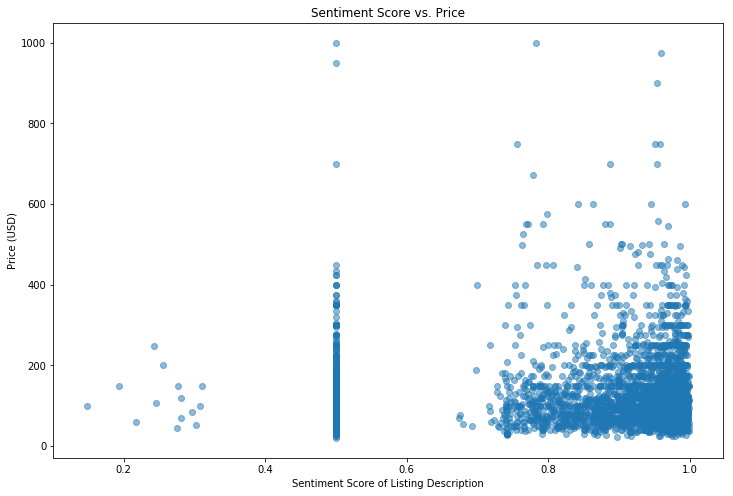

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(airbnb_data_basic['score'], airbnb_data_basic['price'], alpha = .5)
plt.xlabel('Sentiment Score of Listing Description')
plt.ylabel('Price (USD)')
plt.title('Sentiment Score vs. Price')

It was interesting to see that the few that had low sentiment had the lowest prices. Most tended to have high sentiment, which was expected as the descriptions are intended to sell the home. Those that had a neutral sentiment score (0.5) displayed similar attributes to the high sentiment scores, but included much less at the $500+ range. However, as we noted in our regression, this relationship here was not observed to be significant.

### Neighborhood and Price
We then took a look at the relationship between the neighborhood of the listing against the average price of the listing in that neighborhood. 

Text(0.5,0,'Average Price (USD)')

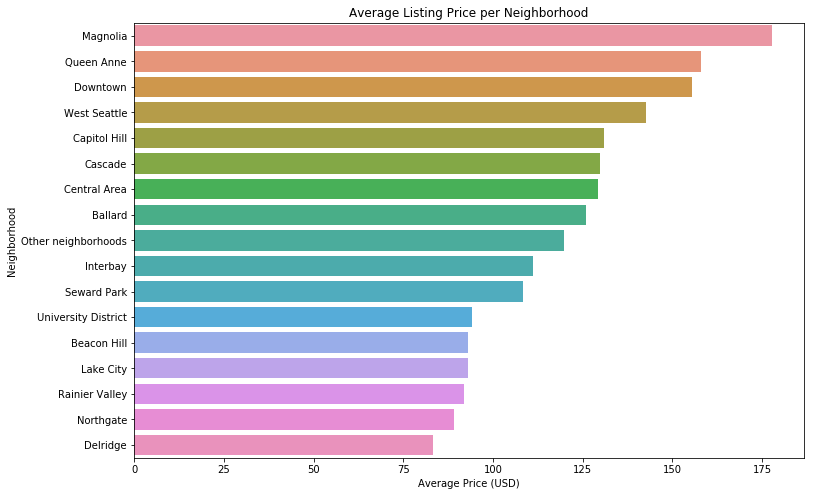

In [7]:
# neighborhood average price comparison 
plt.figure(figsize=(12,8))
prices_by_neighbourhood = airbnb_data_basic.groupby(['neighbourhood']).mean().price.sort_values(ascending=False)
neighbourhood_prices_df = pd.DataFrame(prices_by_neighbourhood)
neighbourhood_prices_df = neighbourhood_prices_df.reset_index()
sns.barplot(x="price", y="neighbourhood", data=neighbourhood_prices_df)
plt.title("Average Listing Price per Neighborhood")
plt.ylabel("Neighborhood")
plt.xlabel("Average Price (USD)")

**Magnolia** stands out from the pack with an average price of nearly 175 dollars, nearly 100 dollars more than the lowest average of **Delridge** at around 75 dollars per listing.

### Price of Listing and Number of Reviews
As our final exploratory visualization, we examined how the `price` of the listing related to the `number of reviews` that the listing had. 

Text(0.5, 1.0, 'Price of Listing vs. Number of Reviews')

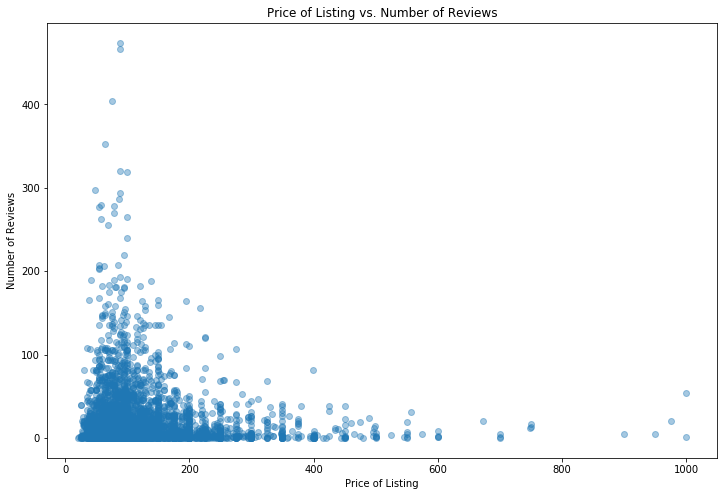

In [4]:
plt.figure(figsize=(12,8))
plt.scatter(airbnb_data_basic['price'], airbnb_data_basic['number_of_reviews'], alpha = 0.4)
plt.xlabel('Price of Listing')
plt.ylabel('Number of Reviews')
plt.title('Price of Listing vs. Number of Reviews')

The graph cascades down nicely and shows that higher priced listings have a significantly lower number of reviews. This is most likely due to them being out of affordable range for the majority of Airbnb users.

## Predicting Price
After exploring our variables, we began our efforts to predict price. We followed the traditional process covered in lecture of splitting our data, building pipelines, and predicting using different ML models.

In [49]:
# split into train and test
train_features, test_features, train_outcome, test_outcome = train_test_split(
    airbnb_data_dummies.drop("price", axis=1),
    airbnb_data_dummies.price,
    test_size=0.20
)

### KNN Regressor
Our first model was K-Nearest Neighbors, varying the polynomial degree of the regression ,the number of neighbors, and the weight function.

In [28]:
# KNN pipeline
knn_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(),
    KNeighborsRegressor()
)

In [29]:
# Grid
knn_param_grid = {
              'polynomialfeatures__degree':range(1,3),
              'kneighborsregressor__n_neighbors':range(1,50,5),
              'kneighborsregressor__weights':['uniform', 'distance']
}

In [30]:
knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=3, scoring="neg_mean_absolute_error")
knn_grid.fit(train_features, train_outcome)
knn_grid.score(test_features, test_outcome)

-38.16366431309363

In [32]:
knn_grid.best_params_

{'kneighborsregressor__n_neighbors': 11,
 'kneighborsregressor__weights': 'distance',
 'polynomialfeatures__degree': 1}

#### KNN Regressor Best Parameters

For our K nearest neighbors regressor we observed the following optimal parameters according to our grid search: 

- Using the closest `11` neighbors
- Using the `distance` weight function when evaluating neighbor influence (defaulted to euclidean) 
- A polynomial degree of `1` was chosen as the best degree out of a range of `(1-3)`


### Random Forests Regressor
Our second model was a Random Forests Regressor, varying the polynomial degree of the regression, the number of trees in the forest, and the maximum depth of each tree.

In [41]:
# RF
rf_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(1),
    RandomForestRegressor()
)

In [42]:
# RF Grid
rf_param_grid = {
              'polynomialfeatures__degree':range(1,3),
              'randomforestregressor__n_estimators':range(1,100, 5),
              'randomforestregressor__max_depth':range(1,5)
}

In [43]:
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring="neg_mean_absolute_error")
rf_grid.fit(train_features, train_outcome)
rf_grid.score(test_features, test_outcome)

-38.00919514435444

In [39]:
rf_grid.best_params_

{'polynomialfeatures__degree': 1,
 'randomforestregressor__max_depth': 4,
 'randomforestregressor__n_estimators': 66}

#### Random Forest Regressor best parameters

For our random forest regressor we observed the following optimal parameters according to our grid search: 

- Using `66` trees in the forest yielded the best results in this combination of parameters
- Using a maximum depth of 4 out of a `(1-5)` range
- A polynomial degree of `1` was chosen as the best degree out of a range of `(1-3)`


### Neural Network Regressor
As a third model, we used a neural network. We varied the learning rate function and the solver technique within our pipeline. 

In [50]:
# Neural Network Pipeline
nn_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(1),
    MLPRegressor()
)

In [51]:
nn_param_grid = {
              'mlpregressor__learning_rate':["constant", "invscaling", "adaptive"],
              'mlpregressor__solver':["lbfgs", "sgd", "adam"],
              'mlpregressor__activation':["relu"]
}

In [52]:
nn_grid = GridSearchCV(nn_pipeline, nn_param_grid, cv=3, scoring="neg_mean_absolute_error")
nn_grid.fit(train_features, train_outcome)
nn_grid.score(test_features, test_outcome)

-32.99291490578755

In [35]:
nn_grid.best_params_

{'mlpregressor__activation': 'relu',
 'mlpregressor__learning_rate': 'adaptive',
 'mlpregressor__solver': 'sgd'}

### Neural Network Regressor Best Parameters

For our neural network multi-layer perceptron regressor we observed the following optimal parameters according to our grid search: 

- Using the `relu` activation function for the hidden layer 
- Using a constant learning rate (over `invscaling`)
- Using a stochastic gradient descent solver for weight optimization
- A polynomial degree of `1` was chosen as the best degree out of a range of `(1-3)`


## Choosing Our Best Model 

After rigorously testing all of models defined above, the model that consistently performed the best was the **multi-layer perceptron** neural net. Out of the three, k nearest neighbor typically reported mean absolute errors in the `(38-35)` range, random forest reported mean absolute errors in the `(37-34)` range, and the neural network scored in the `(35-32)` range. Comparing the spread of each model’s errors against the test data confirms the neural network as the _most accurate_ of the three.

## Visualizing Pricing Predictions

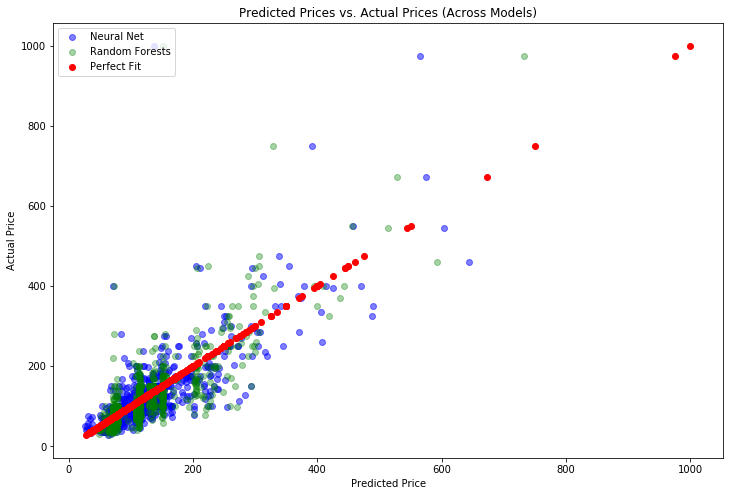

In [53]:
plt.figure(figsize=(12,8))
plt.scatter(nn_grid.predict(test_features),test_outcome,color='b', alpha = .5, label = 'Neural Net')
plt.scatter(rf_grid.predict(test_features),test_outcome,color='g', alpha = .35, label = 'Random Forests')
plt.scatter(test_outcome, test_outcome, color = 'r', label = 'Perfect Fit')
# plt.scatter(knn_grid.predict(test_features),test_outcome,color='r', alpha = .25, label = 'K-Nearest Neighbors')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.legend(loc='upper left')
plt.title("Predicted Prices vs. Actual Prices (Across Models)")

plt.show()

The figure above is a visualization of our predicted prices through both the Random Forests and Neural Net methods, our two best performing models.

We were fairly satisfied with the shape of this plot, with the data generally resembling a pattern of slope 1, which indicates relatively accurate predictions.

Predictions from both models look quite similar, although the numbers indicate that the Neural Net method produced slightly better results. Noticeable differences include the highly concentrated clumping from the Random Forest at different intervals, likely due to the model predicting prices at common price points like 85, 100, and 150. 

## Visualizing Predictive Error

Next, we plotted the error across the different models to see how the difference between prediction and actual prices of listings varied across different parameters. Our first scatterplot illustrates how our error changes across listings of different prices.

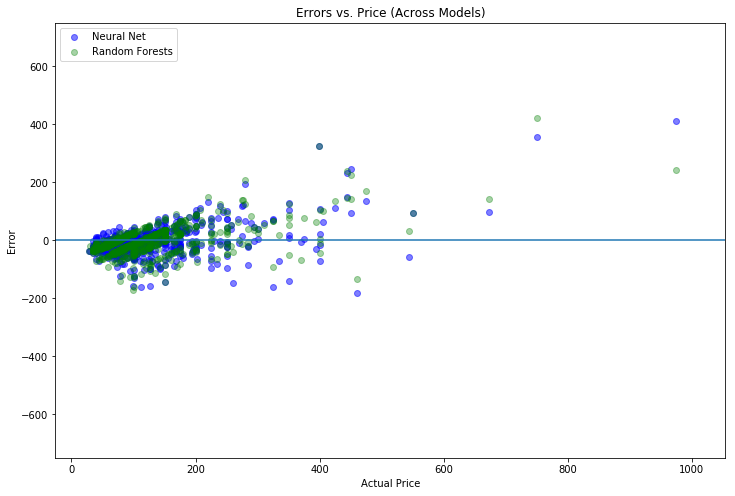

In [54]:
plt.figure(figsize=(12,8))
plt.scatter(test_outcome,test_outcome - nn_grid.predict(test_features),color='b', alpha = .5, label = 'Neural Net')
plt.scatter(test_outcome,test_outcome - rf_grid.predict(test_features),color='g', alpha = .35, label = 'Random Forests')
#plt.scatter(test_outcome,test_outcome - knn_grid.predict(test_features),color='g', alpha = .5, label = 'Random Forests')
plt.axhline(y = 0)
plt.ylim(-750, 750)
plt.xlabel('Actual Price')
plt.ylabel('Error')
plt.title("Errors vs. Price (Across Models)")
plt.legend(loc='upper left')
plt.show()

Again, we were pleasently surprised with how clumped our error was around 0. However, our models becomes less and less accurate as the price of the listing increases. We imagine that this is likely because features that set high-end Airbnb's apart in price (such as privacy of location, quality of home, specific ammenities) were not captured within our dataset. 

In terms of comparing our models, the difference in errors is slight, but the neural net does seem to be clumped a bit more consistently toward zero. 

Interesting observations are that our models seemed to mispredict similar listings. You often see pairs of blue and green dots together, indicating that listings that that one model mispredicts, the other model is likely to mispredict as well. There also appear to be claw-like "streaks" produced by the Random Forest regressor, mirroring the linear patterns in the previous visualization.

###  Error and Property Type 
We then made a violin plot to compare the errors for the Neural Net (our best model) across all property types, to see if we were better or worse at predicting specific properties. 

In [39]:
# prepare data for plotting
listings_clean = pd.read_csv('data/cleaned-listings-base.csv')
property_errors = pd.DataFrame(listings_clean['property_type'])

# get errors for the neural network
nn_errors =  pd.DataFrame(test_outcome - nn_grid.predict(test_features))
nn_errors.rename({"price": "error"}, axis='columns', inplace=True)

# overwrite indexes because this is horrible
nn_errors.index = nn_errors.index.astype(str)
property_errors.index = property_errors.index.astype(str)

res = nn_errors.join(property_errors)

res.error = res.error.abs()

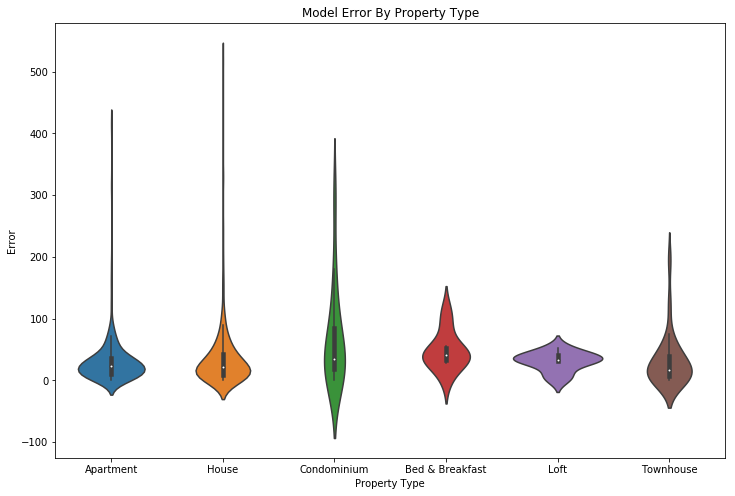

In [40]:
# use this to reset
# sns.reset_orig()


plt.figure(figsize=(12,8))
violin_plot = sns.violinplot(x="property_type", y="error", data=res)

plt.xlabel('Property Type')
plt.ylabel('Error') 
plt.title('Model Error By Property Type')

plt.show(violin_plot)

Apartments, houses, and townhouses appear to have the lowest errors, potentially due to a higher number of listings. However, we also observe huge spikes in error in these property types, especially houses, likely due to outliers on the extremely expensive end. Intuitively, the extremely expensive Airbnb's will likely be large homes and perhaps condominiums, so these naturally will have more extreme high-end outliers. 

# Exploring Airbnb Reviews
After relative success in our effort to predict `price`, we were curious if we could predict the `review_scores_rating`, or the overall review score (on a scale of 1-100), of the Airbnb listing.

We chose to only consider Airbnb's with 3 or more reviews, as we felt that analyzing listings with 0, 1, or 2 ratings would be too subject to outliers to prove valuable in our modeling. 

In [4]:
#Only explore listings with more than 3 reviews
review_data = airbnb_data_dummies[airbnb_data_dummies.number_of_reviews > 3]

## Airbnb Rating Regression
We first conducted a multivariate linear regression to look at how each feature relates to rating.

In [5]:
formula = 'review_scores_rating ~ host_response_rate + accommodates + guests_included + bathrooms + bedrooms + beds + number_of_reviews + price + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + score + host_is_superhost + neighbourhood_Ballard  + neighbourhood_Cascade  + neighbourhood_Delridge + neighbourhood_Downtown + neighbourhood_Interbay + neighbourhood_Magnolia + neighbourhood_Northgate + property_type_Apartment  + property_type_Condominium + property_type_House + property_type_Loft + property_type_Townhouse + neighbourhood_Beacon_Hill + neighbourhood_Capitol_Hill + neighbourhood_Central_Area + neighbourhood_Lake_City + neighbourhood_Other_neighborhoods + neighbourhood_Queen_Anne + neighbourhood_Rainier_Valley + neighbourhood_Seward_Park + neighbourhood_University_District + neighbourhood_West_Seattle + property_type_Bed_Breakfast + room_type_Entire_home_apt + room_type_Private_room + room_type_Shared_room'

mod1 = smf.ols(formula=formula, data=review_data).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.719
Model:                              OLS   Adj. R-squared:                  0.715
Method:                   Least Squares   F-statistic:                     156.6
Date:                  Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                          20:48:03   Log-Likelihood:                -5878.0
No. Observations:                  2424   AIC:                         1.184e+04
Df Residuals:                      2384   BIC:                         1.207e+04
Df Model:                            39                                         
Covariance Type:              nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.4186      1.062     -0.394      0.694      -2.502       1.664
host_response_rate                    0.0064      0.006      1.123      0.261      -0.005       0.018
accommodates                         -0.0259      0.071     -0.367      0.714      -0.164       0.113
guests_included                      -0.0542      0.054     -1.003      0.316      -0.160       0.052
bathrooms                             0.1847      0.133      1.387      0.166      -0.077       0.446
bedrooms                              0.0574      0.128      0.450      0.653      -0.193       0.308
beds                                 -0.0528      0.105     -0.501      0.616      -0.260       0.154
number_of_reviews                    -0.0029      0.001     -2.014      0.044      -0.006   -7.51e-05
price                                 0.0036      0.001      3.477      0.001       0.002       0.006
review_scores_accuracy                1.6449      0.135     12.158      0.000       1.380       1.910
review_scores_cleanliness             2.0059      0.108     18.527      0.000       1.794       2.218
review_scores_checkin                 1.3627      0.169      8.077      0.000       1.032       1.694
review_scores_communication           1.7533      0.177      9.931      0.000       1.407       2.100
review_scores_location                0.9317      0.120      7.785      0.000       0.697       1.166
review_scores_value                   2.1174      0.125     16.935      0.000       1.872       2.363
score                                -0.1687      0.325     -0.519      0.604      -0.806       0.469
host_is_superhost                     0.6906      0.136      5.077      0.000       0.424       0.957
neighbourhood_Ballard                -0.4352      0.244     -1.786      0.074      -0.913       0.043
neighbourhood_Cascade                 0.1460      0.411      0.355      0.722      -0.660       0.952
neighbourhood_Delridge                0.5759      0.380      1.517      0.129      -0.168       1.320
neighbourhood_Downtown                0.0275      0.211      0.131      0.896      -0.386       0.441
neighbourhood_Interbay                1.2832      1.069      1.200      0.230      -0.813       3.380
neighbourhood_Magnolia               -0.1803      0.465     -0.388      0.698      -1.092       0.731
neighbourhood_Northgate              -0.6475      0.422     -1.536      0.125      -1.474       0.179
property_type_Apartment              -0.3143      0.243     -1.293      0.196      -0.791       0.162
property_type_Condominium            -0.1195      0.437     -0.274      0.784      -0.976       0.737
property_type_House                  -0.2185      0.243     -0.899      0.369      -0.695       0.258
p

These results were a bit conflicting. While we yielded an R-squared of **.719**, checking the variables of significance reveal that this is almost entirely due to the sub-scores that are contained in our dataset.

On Airbnb, there is both an overall rating represented by our dependent variable `review_scores_rating`, as well as several sub-ratings that we touched on earlier. Because using sub-scores to predict an overall score feels a bit lazy, we decided to test out predictive abilities both with and without those sub-scores included. 

With that being said, a few additional variables did, in fact, have a significant relationship to the overall rating, such as `price`, the `number of reviews` (surprisingly this was a negative relationship), and whether or not the host was an Airbnb "superhost".

In [6]:
# Drop sub-review scores in one subset. Using sub-scores to predict overall scores is kind of cheating
review_data_no_subs = review_data.drop('review_scores_accuracy',1)
review_data_no_subs = review_data_no_subs.drop('review_scores_cleanliness',1)
review_data_no_subs = review_data_no_subs.drop('review_scores_checkin',1)
review_data_no_subs = review_data_no_subs.drop('review_scores_communication',1)
review_data_no_subs = review_data_no_subs.drop('review_scores_location',1)
review_data_no_subs = review_data_no_subs.drop('review_scores_value',1)

## Regression Without Sub-Scores:

In [7]:
formula = 'review_scores_rating ~ host_response_rate + accommodates + guests_included + bathrooms + bedrooms + beds + number_of_reviews + price + score + host_is_superhost + neighbourhood_Ballard  + neighbourhood_Cascade  + neighbourhood_Delridge + neighbourhood_Downtown + neighbourhood_Interbay + neighbourhood_Magnolia + neighbourhood_Northgate + property_type_Apartment  + property_type_Condominium + property_type_House + property_type_Loft + property_type_Townhouse + neighbourhood_Beacon_Hill + neighbourhood_Capitol_Hill + neighbourhood_Central_Area + neighbourhood_Lake_City + neighbourhood_Other_neighborhoods + neighbourhood_Queen_Anne + neighbourhood_Rainier_Valley + neighbourhood_Seward_Park + neighbourhood_University_District + neighbourhood_West_Seattle + property_type_Bed_Breakfast + room_type_Entire_home_apt + room_type_Private_room + room_type_Shared_room'
mod1 = smf.ols(formula=formula, data=review_data).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.190
Model:                              OLS   Adj. R-squared:                  0.178
Method:                   Least Squares   F-statistic:                     16.94
Date:                  Tue, 04 Dec 2018   Prob (F-statistic):           5.77e-86
Time:                          20:48:08   Log-Likelihood:                -7162.7
No. Observations:                  2424   AIC:                         1.439e+04
Df Residuals:                      2390   BIC:                         1.459e+04
Df Model:                            33                                         
Covariance Type:              nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            55.9933      0.701     79.865      0.000      54.619      57.368
host_response_rate                    0.0639      0.009      6.730      0.000       0.045       0.083
accommodates                         -0.4196      0.119     -3.520      0.000      -0.653      -0.186
guests_included                      -0.0439      0.092     -0.479      0.632      -0.224       0.136
bathrooms                             0.4336      0.225      1.924      0.054      -0.008       0.876
bedrooms                              0.1790      0.216      0.829      0.407      -0.245       0.602
beds                                  0.0241      0.179      0.135      0.893      -0.326       0.374
number_of_reviews                    -0.0019      0.002     -0.795      0.427      -0.007       0.003
price                                 0.0074      0.002      4.206      0.000       0.004       0.011
score                                 0.4080      0.551      0.741      0.459      -0.672       1.488
host_is_superhost                     3.3366      0.220     15.139      0.000       2.904       3.769
neighbourhood_Ballard                 3.4956      0.390      8.962      0.000       2.731       4.261
neighbourhood_Cascade                 2.8058      0.689      4.075      0.000       1.456       4.156
neighbourhood_Delridge                4.7089      0.631      7.464      0.000       3.472       5.946
neighbourhood_Downtown                3.1369      0.332      9.462      0.000       2.487       3.787
neighbourhood_Interbay                4.6112      1.810      2.548      0.011       1.062       8.161
neighbourhood_Magnolia                2.7767      0.779      3.563      0.000       1.248       4.305
neighbourhood_Northgate               3.9788      0.704      5.652      0.000       2.598       5.359
property_type_Apartment               8.6608      0.311     27.832      0.000       8.051       9.271
property_type_Condominium            10.0250      0.682     14.705      0.000       8.688      11.362
property_type_House                   8.8591      0.313     28.312      0.000       8.246       9.473
property_type_Loft                    8.5975      0.864      9.951      0.000       6.903      10.292
property_type_Townhouse              10.5966      0.602     17.595      0.000       9.416      11.778
neighbourhood_Beacon_Hill             2.8665      0.528      5.429      0.000       1.831       3.902
neighbourhood_Capitol_Hill            2.5752      0.303      8.509      0.000       1.982       3.169
neighbourhood_Central_Area            4.0713      0.333     12.211      0.000       3.417       4.725
neighbourhood_Lake_City               2.9169      0.701      4.163      0.000       1.543       4.291
n

Unsurprisingly, this tanked our R-squared value, now residing at **.190**, indicating that our remaining variables only account for **20%** of the variation in Airbnb rating. We hypothesized that this is because the variables we are left with only represent a small fraction of what goes into a positive or negative Airbnb experience. We are simply using detials like the `property type`, `neighborhood`, and `price` to explain a rating.

The bright side is that many of these are, in fact, significant, and provide us with some insight into what contributes to positive or negative scores. 

A few interesting relationships are price, with a positive relationship to rating, indicating that more expensive Airbnbs generally have higher overall ratings. `host_is_superhost` has a positive relationship with rating, a relationship that makes sense intuitively, as better, more experienced hosts perhaps provide better experiences to renters. 

# Predicting AirBNB Ratings
We then moved on to predicting these ratings. As this was not the main focus of the project, we decided to just test a single model type and see how it faired. We also understood that the average rating for our listings with more than 3 reviews was:

In [8]:
avg_rating = review_data_no_subs.review_scores_rating.mean()
avg_rating

94.60519801980197

with a variance of:

In [9]:
review_data_no_subs.review_scores_rating.var()

26.643489271543483

This high mean and low variance means that the differences in any given listings was generally quite small, and with our R-squared of only **.19** in the case of the sub-score-free dataset, we were attempting to predict small variations with little of the explanatory data behind those variations. However, we figured we would give it a go anyway.

## Neural Net Predictive Model
We followed the same process as our predictions for price. We performed our predictions with and without the sub-scores in two different models.

### Without Sub-Scores

In [10]:
# split into train and test
train_features, test_features, train_outcome, test_outcome = train_test_split(
    review_data_no_subs.drop("review_scores_rating", axis=1),
    review_data_no_subs.review_scores_rating,
    test_size=0.20
)

In [11]:
nn_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(),
    MLPRegressor()
)

In [12]:
nn_param_grid = {
              'polynomialfeatures__degree':range(1,3),
              'mlpregressor__learning_rate':["constant", "invscaling", "adaptive"],
              'mlpregressor__solver':["lbfgs", "sgd", "adam"],
              'mlpregressor__activation':["relu"]
}


In [13]:
nn_grid_no_subs = GridSearchCV(nn_pipeline, nn_param_grid, cv=3, scoring="neg_mean_absolute_error")
nn_grid_no_subs.fit(train_features, train_outcome)
nn_grid_no_subs.score(test_features, test_outcome)

-3.1204479236185922

While this negative mean absolute error of around **3.00** appears to be extremely impressive, our variance is so low that this is not some remarkable feat. In fact, if we simply predict the rating to be the average overall Airbnb rating in this dataset and measure the mean_absolute_error, we see a relatively similar score: 

In [14]:
mean_absolute_error([avg_rating] * len(test_outcome), test_outcome)

3.4570455241400446

### With Sub-Scores
Using the dataset that contains the sub-scores, we expect this error to improve more significantly.

In [16]:
# split into train and test
train_features_2, test_features_2, train_outcome_2, test_outcome_2 = train_test_split(
    review_data.drop("review_scores_rating", axis=1),
    review_data.review_scores_rating,
    test_size=0.20
)

In [17]:
# Using same pipeline as prior
nn_grid_with_subs = GridSearchCV(nn_pipeline, nn_param_grid, cv=3, scoring="neg_mean_absolute_error")
nn_grid_with_subs.fit(train_features_2, train_outcome_2)
nn_grid_with_subs.score(test_features_2, test_outcome_2)

-1.9765868076458053

As expected, this NMAE of around **-2.00** is a fair amount less than the model that excluded the sub-scores.

## Visualizing Our Predictions
To visualize our predictive results with the neural net, we first made a plot to view any correlation between the actual and the predicted rating for the dataset that **excluded** sub-scores. 

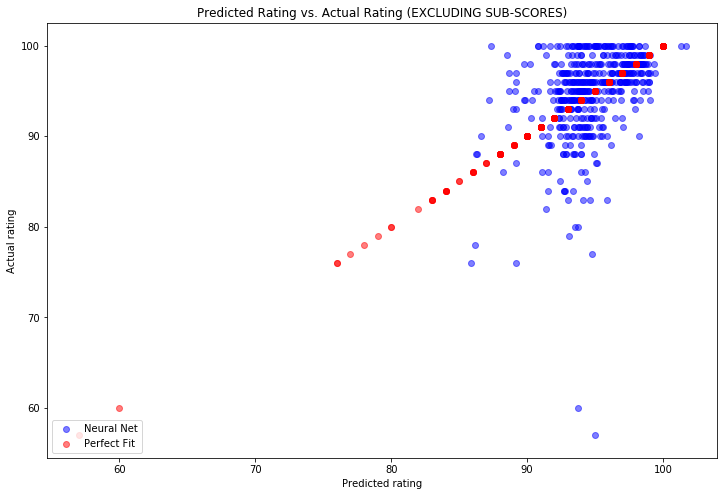

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(nn_grid_no_subs.predict(test_features),test_outcome,color='b', alpha = .5, label = 'Neural Net')
plt.scatter(test_outcome,test_outcome,color='red', alpha = .5, label = 'Perfect Fit')
# plt.scatter([avg_rating] * len(test_outcome),test_outcome,color='g', alpha = .5, label = 'Average Rating')
plt.xlabel('Predicted rating')
plt.ylabel('Actual rating')
plt.legend(loc='lower left')
# plt.xlim(right = 100)
# plt.xlim(left = 60)
plt.title('Predicted Rating vs. Actual Rating (EXCLUDING SUB-SCORES)')
plt.show()

This visualization demonstrates that, unsurprisingly, our neural network did not do a great job predicting score when with the sub-scores excluded. The distribution of the points do not resemble any kind of y=x line like our price predictions did previously, which would indicate good predictive accuracy.

Contrasting this with the visualized predictions **using sub-scores**:

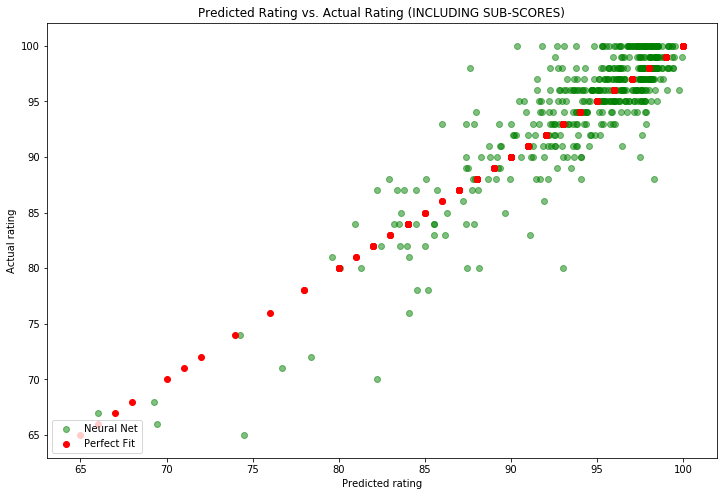

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(nn_grid_with_subs.predict(test_features_2),test_outcome_2,color='g', alpha = .5, label = 'Neural Net')
plt.scatter(test_outcome_2,test_outcome_2,color='red', label = 'Perfect Fit')
# plt.scatter([avg_rating] * len(test_outcome),test_outcome,color='g', alpha = .5, label = 'Average Rating')
plt.xlabel('Predicted rating')
plt.ylabel('Actual rating')
plt.legend(loc='lower left')
#plt.xlim(right = 100)
#plt.xlim(left = 60)
plt.title('Predicted Rating vs. Actual Rating (INCLUDING SUB-SCORES)')
plt.show()

...and we see a distribution that strongly resembles that y=x line. These differences go to show that while we can reasonably predict Airbnb reviews if we have access to those sub-scores, without them, our predictions plummet in accuracy.

A final look at error against ratings tell a similar story. The error we would yield from simply predicting the average rating for every test case is included in the first graph to demonstrate the lack of significant difference between our model and this crude predictor. 

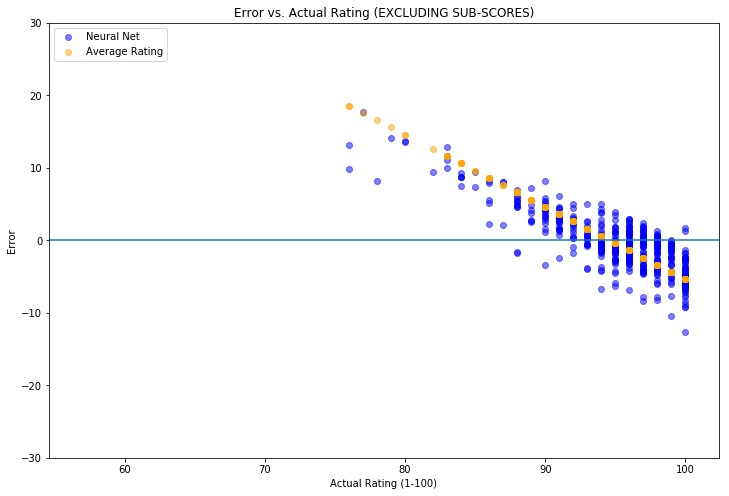

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(test_outcome,nn_grid_no_subs.predict(test_features) - test_outcome,color='b', alpha = .5, label = 'Neural Net')
plt.scatter(test_outcome,[avg_rating] * len(test_outcome) - test_outcome,color='orange', alpha = .5, label = 'Average Rating')
plt.axhline(y=0)
plt.xlabel('Actual Rating (1-100)')
plt.title('Error vs. Actual Rating (EXCLUDING SUB-SCORES)')
plt.legend(loc='upper left')
plt.ylabel('Error')
plt.ylim(-30,30)
plt.show()

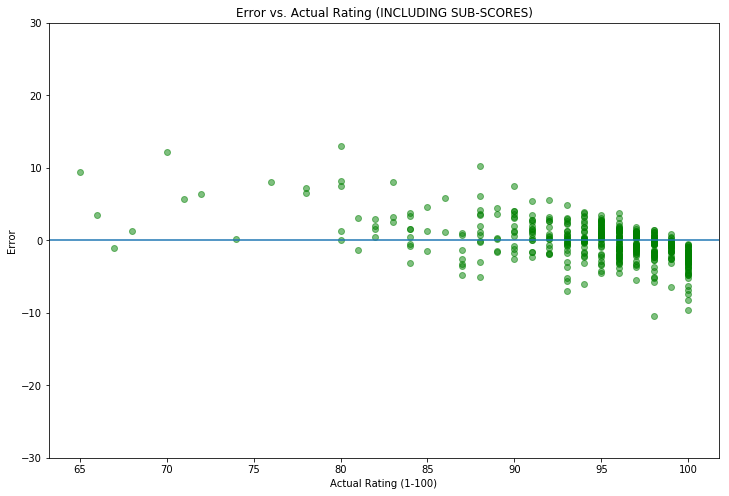

In [48]:
plt.figure(figsize=(12,8))
plt.scatter(test_outcome_2,nn_grid_with_subs.predict(test_features_2) - test_outcome_2,color='g', alpha = .5, label = 'Neural Net')
plt.axhline(y=0)
plt.xlabel('Actual Rating (1-100)')
plt.title('Error vs. Actual Rating (INCLUDING SUB-SCORES)')
plt.ylabel('Error')
plt.ylim(-30,30)
plt.show()

The second graph representing the error from the dataset using those sub-scores is significantly more centered around 0, regardless of the actual rating, indicating higher predictive accuracy.

This goes to show that while we have a fairly strong ability to predict overall Airbnb `rating` when given access to sub-ratings, our ability to make these predictions without these intermediate ratings is fairly worthless.